
# Advanced Text Analytics

## Background
Since last year, grocery delivery has become fashionable in South Africa. Some of the market 
leaders in the grocery delivery sector in South Africa include Checkers, Pick n Pay, 
Woolworths and OneCart. These companies use mobile apps whereby customers can 
purchase products, and they deliver them to their doorsteps. Game South Africa is interested
in entering the grocery delivery market and wants to deploy a mobile app for that. However, 
they want to learn from current market leaders to ensure their success. Their goal is to adopt 
the things that are good and correct those that are bad. The company knows that text analytics
can help them gather insights from customer reviews of similar apps from market leaders and 
use the insights in deploying their own service. 

# Objective
As a data scientist, you have been approached by Game to work on this project. Using the 
dataset provided to you (“Grocery Delivery Apps.csv”), answer the questions listed in the document. The 
dataset contains 11276 customer reviews from four grocery delivery mobile apps in South 
Africa. The App details are provided below


| App Name | App AppId |Company |
|----------|-----------|--------|
|Pick n Pay  ASAP! (Bottles) |com.bottles| Pick n Pay |
|Woolies Dash| za.co.woolworths.dash| Woolworths SA|
|OneCart |za.co.onecart.onecart| OneCart|
|Checkers Sixty60| za.co.shoprite.sixty60| Checkers|




In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 8.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 59 kB/s 
     |████████████████████████████████| 11.3 MB 49.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=ec5e3fa5e6badf6add37411d6aba37e7f93b043efe69589e404e1689025d3839
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models as pygen

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

stop_words.extend(['make', 'want', 'seem', 'run', 'need', 'even', 'not', 'would', 'say', 'could', '_', 
                'be', 'know', 'go', 'get', 'do','get','far','also','way','app','usd','eur','jai','hind','jai_hind',
'done', 'try', 'many','from', 'subject', 're', 'edu','some', 'nice', 'thank','singh','mast','untuk','apne','nise','vgood',
'think', 'see', 'rather', 'lot', 'line', 'even', 'also', 'may', 'use','goog','nce','aap','thik','hai','setu','aarogya_setu','aarogya',
'take', 'come','recommend','recommended','paypal','paytm', 'let','ad','add'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import files
data = files.upload()

Saving Grocery Delivery Apps.csv to Grocery Delivery Apps (1).csv


In [ ]:
# Import Dataset
data_ = pd.read_csv ('Grocery Delivery Apps.csv')

## Positive Reviews

1.1. Identify the things that people love about grocery delivery apps

In [ ]:
df_pos = data_.loc[data_["score"] >3]
df_pos['content']=df_pos['content'].apply(str)
df_pos.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,appId,Date,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,sortOrder,thumbsUpCount,userImage,userName
1919,com.bottles,2021/10/13 08:40,Not the most pleasant customer care experience...,2021/10/13 08:23,We understand this can be frustrating. We are ...,6.1,gp:AOqpTOHYYUupH5Gnpvyoj5lekRfdAVe24Jfi_hZMFWn...,4,newest,17,https://play-lh.googleusercontent.com/a-/AOh14...,Matome Sebali
1920,com.bottles,2021/10/18 10:27,The app is user friendly. Delivery is very fas...,2021/10/18 10:40,Thank you for your feedback. We are working on...,6.1,gp:AOqpTOFapyIbWw_zC0uQNJpYKkjuw6FbdImPJ4agmbr...,4,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Kgotlopong Khomotso Mojela
1921,com.bottles,2021/10/03 11:55,I've tested the app today for the first. I'm h...,2021/10/06 08:27,"Dear User, Thank you for your suggestions. We ...",6.1,gp:AOqpTOH83x-7PT3eSfyb9O_cuu57wNLLI0a07slvzIr...,4,newest,12,https://play-lh.googleusercontent.com/a-/AOh14...,Dewald Jooste
1922,com.bottles,2021/10/14 10:07,I really enjoyed the experience of online shop...,2021/10/14 13:37,Thank you for providing your valuable feedback...,6.1,gp:AOqpTOGW0nBS2Xg5tFjNADZVDRzbXGkgxCjGnMWl_OG...,4,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Sandile Nkosi
1923,com.bottles,2021/10/03 14:25,Service was fast and accurate. App could use a...,2021/10/06 08:17,Thank you for providing your valuable feedback...,6.1,gp:AOqpTOHMg7n9FUyMTXlrc1xT3w-_6qbVQFnpNMJoLIu...,4,newest,2,https://play-lh.googleusercontent.com/a-/AOh14...,Peter Baker


In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub('[^a-zA-Z0-9]',' ',sent) # remove non english words
        sent = re.sub('\s+',' ',sent) # remove non english words
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data_pos = df_pos.content.values.tolist()
data_words_pos = list(sent_to_words(data_pos))
print(data_words_pos[:1])

[['not', 'the', 'most', 'pleasant', 'customer', 'care', 'experience', 'took', 'days', 'for', 'them', 'to', 'respond', 'to', 'my', 'email', 'spent', 'days', 'in', 'the', 'dark', 'without', 'knowing', 'whether', 'or', 'not', 'my', 'problem', 'is', 'being', 'attended', 'to', 'but', 'in', 'the', 'end', 'received', 'an', 'email', 'saying', 'that', 'my', 'issue', 'has', 'been', 'resolved', 'and', 'ill', 'get', 'full', 'refund', 'for', 'items', 'wasnt', 'satisfied', 'with', 'overall', 'the', 'whole', 'shopping', 'experience', 'has', 'been', 'flawless', 'normally', 'receive', 'my', 'items', 'within', 'minutes', 'after', 'placing', 'my', 'orders']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_pos, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_pos], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready_pos = process_words(data_words_pos)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Create Dictionary
id2word_pos = corpora.Dictionary(data_ready_pos)

# Create Corpus: Term Document Frequency
corpus_pos = [id2word_pos.doc2bow(text) for text in data_ready_pos]

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=data_ready_pos, dictionary=id2word_pos, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

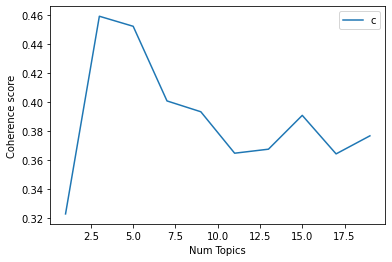

In [ ]:
pos_model_list, pos_coherence_values = compute_coherence_values(dictionary=id2word_pos, corpus=corpus_pos, texts=data_ready_pos, start=1, limit=20, step=2)
# Show graph
import matplotlib.pyplot as plt
limit=20; start=1; step=2;
x = range(start, limit, step)
plt.plot(x, pos_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Build LDA model
lda_model_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
                                           

pprint(lda_model_pos.print_topics())

[(0,
  '0.171*"good" + 0.083*"time" + 0.055*"order" + 0.051*"delivery" + '
  '0.041*"service" + 0.034*"deliver" + 0.032*"always" + 0.029*"great" + '
  '0.023*"well" + 0.019*"hour"'),
 (1,
  '0.119*"shopping" + 0.043*"update" + 0.035*"fantastic" + 0.028*"customer" + '
  '0.027*"highly" + 0.027*"experience" + 0.025*"save" + 0.021*"live" + '
  '0.019*"feature" + 0.018*"otherwise"'),
 (2,
  '0.034*"impress" + 0.025*"delivery" + 0.022*"perfect" + 0.022*"home" + '
  '0.022*"tip" + 0.021*"purchase" + 0.020*"min" + 0.018*"issue" + '
  '0.018*"payment" + 0.016*"month"'),
 (3,
  '0.226*"checker" + 0.098*"amazing" + 0.037*"store" + 0.031*"special" + '
  '0.014*"lockdown" + 0.013*"stuff" + 0.012*"suggestion" + 0.011*"deliver" + '
  '0.010*"sort" + 0.010*"include"'),
 (4,
  '0.073*"delivery" + 0.070*"friendly" + 0.044*"love" + 0.043*"minute" + '
  '0.035*"driver" + 0.034*"option" + 0.032*"user" + 0.029*"super" + '
  '0.029*"available" + 0.028*"order"'),
 (5,
  '0.090*"shop" + 0.075*"experience" + 0

In [ ]:
pyLDAvis.enable_notebook()
vis = pygen.prepare(lda_model_pos, corpus_pos, dictionary=lda_model_pos.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.234140  0.045283       1        1  18.660571
6     -0.119354  0.248700       2        1  14.277264
4     -0.071282  0.110001       3        1  13.116137
7     -0.228416 -0.257816       4        1   9.520334
8      0.146862 -0.092346       5        1   8.144135
2      0.049084  0.132505       6        1   7.955396
1      0.177034  0.005882       7        1   7.531947
3      0.181757 -0.023455       8        1   7.439261
9     -0.008673 -0.151951       9        1   7.022571
5      0.107129 -0.016803      10        1   6.332385, topic_info=            Term         Freq        Total Category  logprob  loglift
144         good  1409.000000  1409.000000  Default  30.0000  30.0000
225      checker   656.000000   656.000000  Default  29.0000  29.0000
92       service  1148.000000  1148.000000  Default  28.0000  28.0000
266    excellent   687.000000   687.000000  Default  27.0000  27.0000
88         great   700.000000   700.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1152       paper     9.898903    11.171614  Topic10  -5.5192   2.6385
58      consider     9.882195    11.154767  Topic10  -5.5209   2.6384
7     experience   185.272640   376.608910  Topic10  -2.5898   2.0501
144         good   164.685704  1409.781437  Topic10  -2.7076   0.6123
77        really    38.578517   219.669899  Topic10  -4.1589   1.0201

[405 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
652      10  0.900898     ability
279       3  0.985053        able
610       9  0.989127  absolutely
757       5  0.885711      access
805       8  0.911618     account
...     ...       ...         ...
836       8  0.956831       worth
398       2  0.937400       wrong
571       2  0.975897        year
443       4  0.920641   yesterday
775       2  0.977909         yet

[386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 5, 8, 9, 3, 2, 4, 10, 6])

In [ ]:
pyLDAvis.save_html(vis, 'PositiveTopics.html')

### Wordclouds on top 10 positive review topics

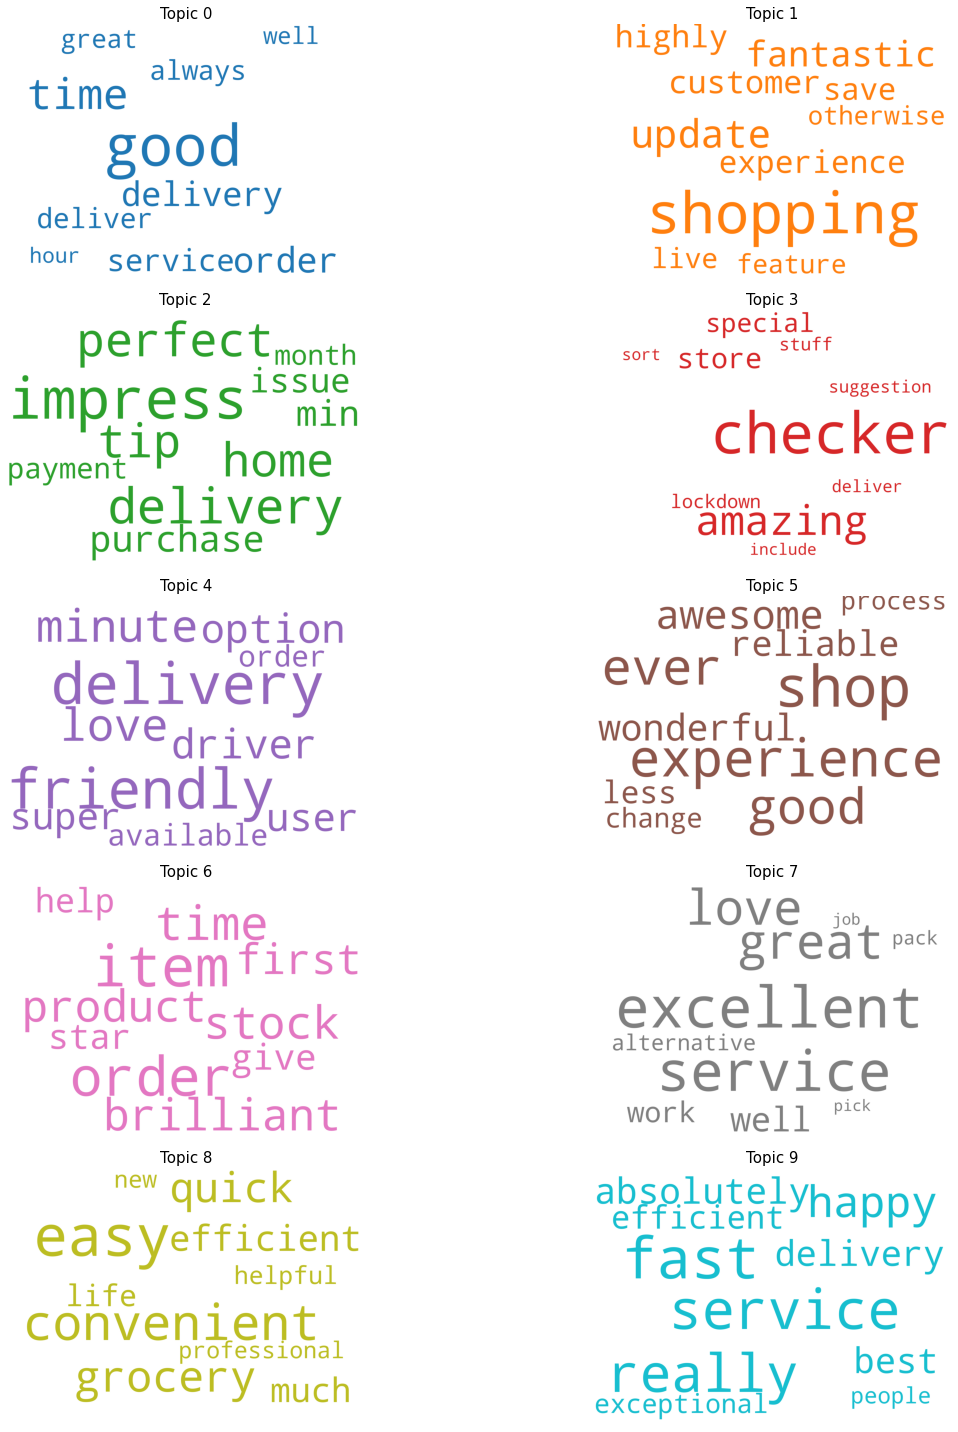

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_pos.show_topics(formatted=False)



fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=15))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('pos_wordcloud_plot.png', dpi=300)
plt.show()

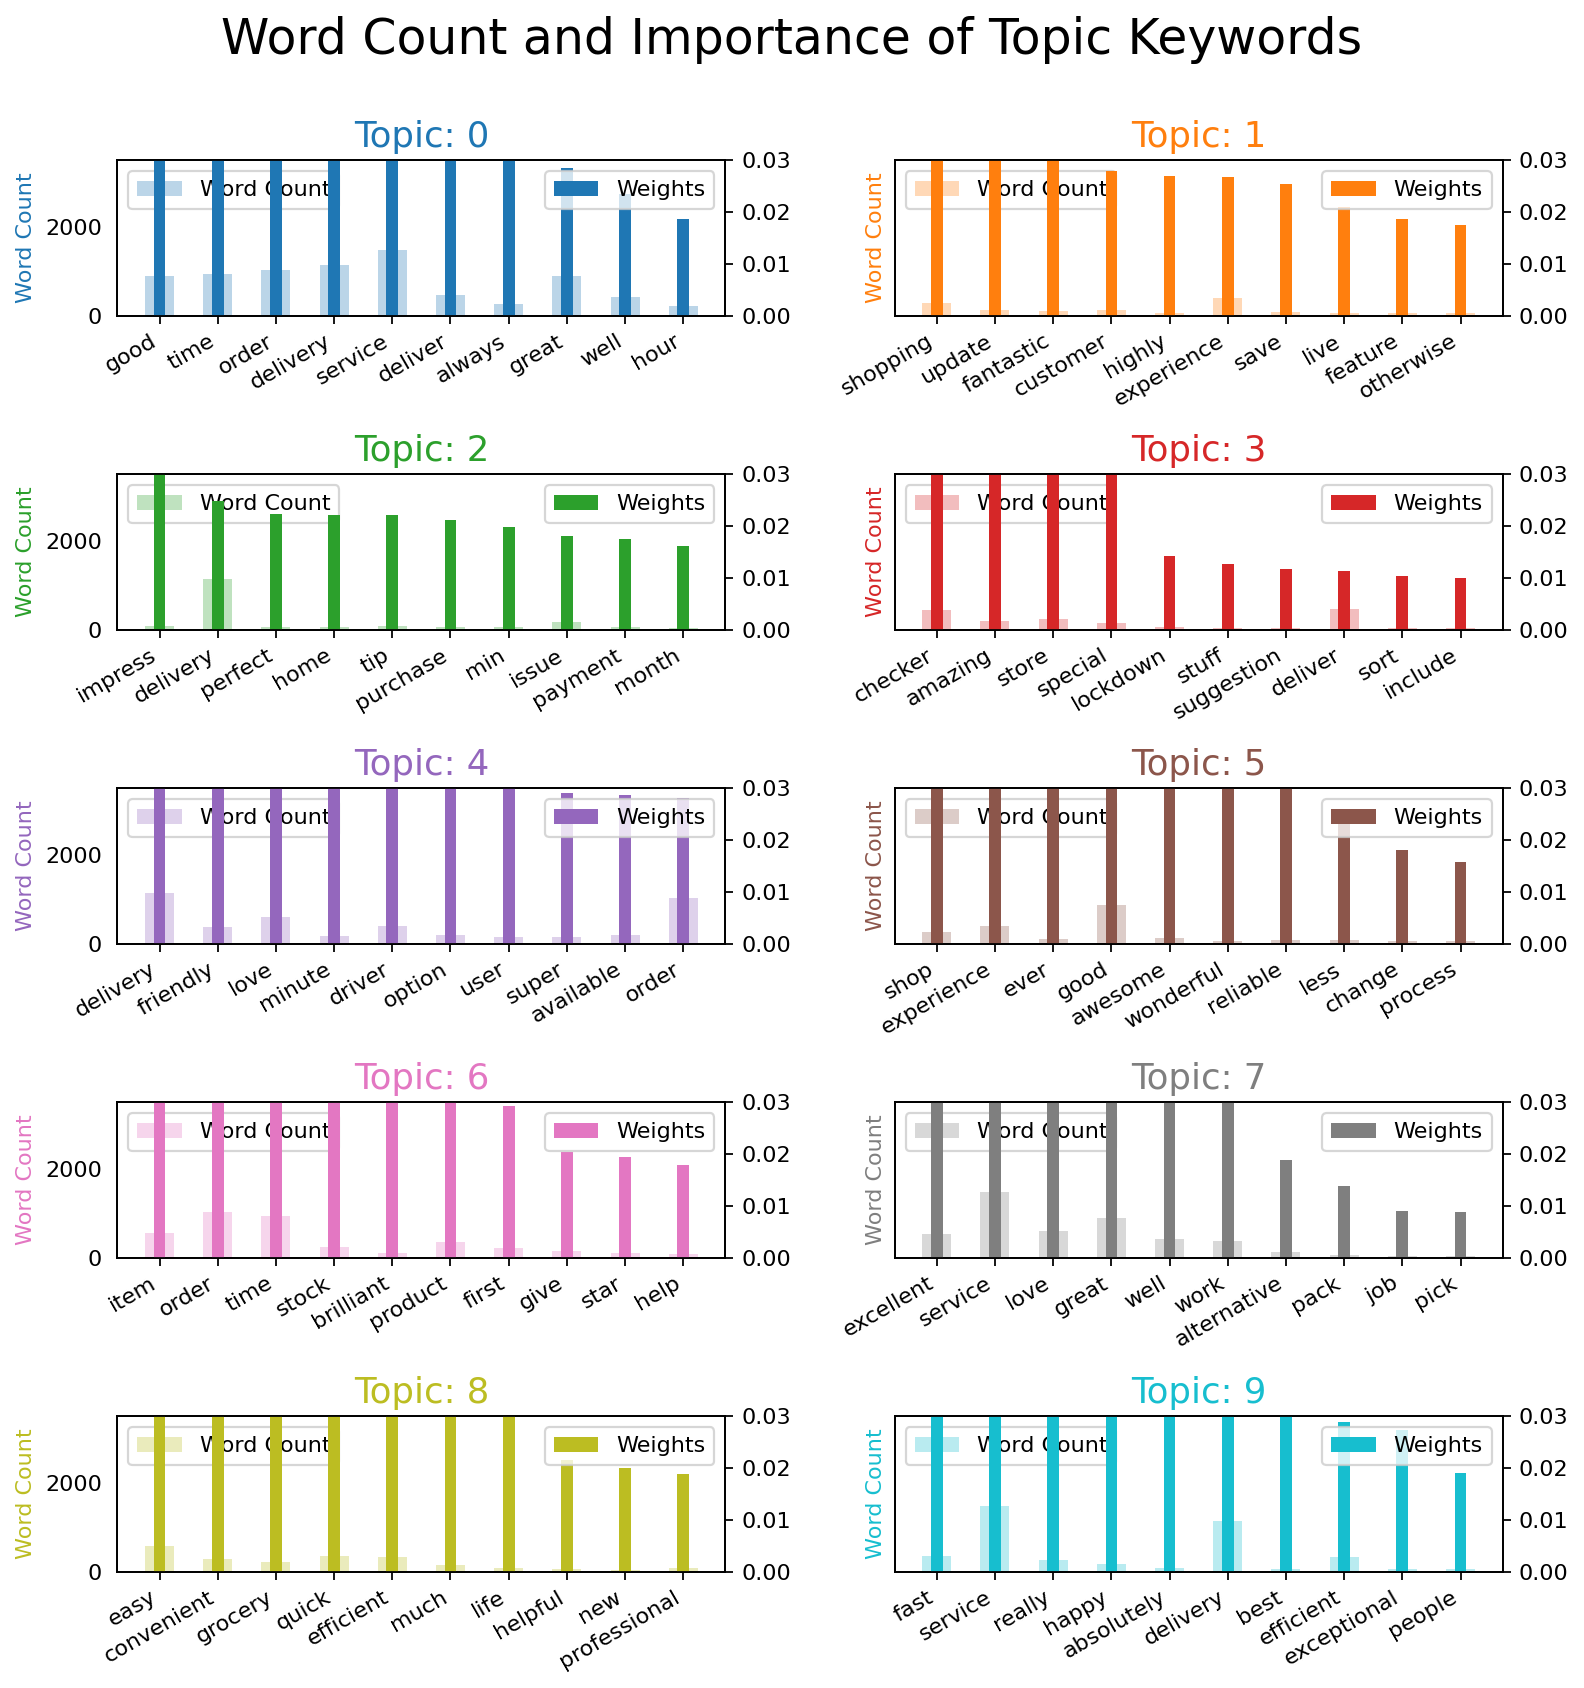

In [ ]:
from collections import Counter
topics = lda_model_pos.show_topics(formatted=False)
data_flat = [w for w_list in data_ready_pos for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

**Observations**

Based on the word frequency plots, wordclouds and pyLDAvis plot above, we can deduce that the following are aspects that customers like about the grocery apps:

- Timely product delivery
- Good customer service. Staff (customer service operators and drivers) are friendly, efficient and helpful.
- The app interface is easy to use (user friendly). It provides a convinient way to do grocery shopping during lockdown.
- The apps are fairly reliable
- There is almost always stock, and if not, assistance is provided on when stock will be available.

## Negative Reviews
### 1.2. Identify the things that people hate about grocery delivery apps.


In [ ]:
df_neg = data_.loc[data_["score"] <3]
df_neg['content']=df_neg['content'].apply(str)
df_neg.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,appId,Date,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,sortOrder,thumbsUpCount,userImage,userName
0,com.bottles,2021/09/12 13:28,The selection is very small. It gets packed fa...,NaN,NaN,6,gp:AOqpTOEBCgQptRmaQQ7uUAJ1389mXczv2DcxijpnClU...,1,newest,212,https://play-lh.googleusercontent.com/a-/AOh14...,Michaela Justus
1,com.bottles,2021/10/18 17:55,Worst service EVER!!!! Ordered groceries at 14...,2021/10/18 17:46,"Dear User,\r\nWe apologize for the issue. Coul...",6.1,gp:AOqpTOEhpgX3UejWavuzVa3oCkqOZQ7XyacyqS2IWdM...,1,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Zizipho Magungxu
2,com.bottles,2021/10/15 09:49,Used app many times. Service deteriorated. Ord...,2021/10/15 08:13,Please accept our sincere apologies. Can you p...,6.1,gp:AOqpTOHTu2LMMgZBdInbvzU8hVrGuVgJvSviu5oNjFm...,1,newest,1,https://play-lh.googleusercontent.com/a-/AOh14...,Robert King
3,com.bottles,2021/10/14 18:56,"Tried to order, I input the promo code & was a...",2021/10/15 08:18,We'll look into this issue for you. Please sen...,6.1,gp:AOqpTOHErJpJ5H0VkPzNbl9YCIwIql8Ft4TpsFQgFbZ...,1,newest,1,https://play-lh.googleusercontent.com/a-/AOh14...,Chants K
4,com.bottles,2021/10/11 09:30,"I'm highly disappointed in this service, I alw...",2021/10/12 08:23,Please accept our sincere apologies. Can you p...,6.1,gp:AOqpTOGE9247xQamppdJ16IrmN0apuJ-_N4jLGsAXC_...,1,newest,3,https://play-lh.googleusercontent.com/a/AATXAJ...,cezanne bartes


In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub('[^a-zA-Z0-9]',' ',sent) # remove non english words
        sent = re.sub('\s+',' ',sent) # remove non english words
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data_neg = df_neg.content.values.tolist()
data_words_neg = list(sent_to_words(data_neg))
print(data_words_neg[:1])

[['the', 'selection', 'is', 'very', 'small', 'it', 'gets', 'packed', 'fairly', 'quickly', 'but', 'the', 'delivery', 'system', 'is', 'dismal', 'have', 'ordered', 'or', 'times', 'and', 'there', 'has', 'been', 'problem', 'most', 'times', 'today', 'whatched', 'the', 'driver', 'on', 'the', 'map', 'and', 'went', 'outside', 'to', 'meet', 'him', 'he', 'did', 'not', 'bother', 'to', 'ring', 'the', 'doorbell', 'my', 'order', 'was', 'returned', 'to', 'the', 'shop', 'and', 'cancelled', 'other', 'times', 'bags', 'have', 'been', 'left', 'outside', 'in', 'the', 'road', 'it', 'seems', 'that', 'the', 'drivers', 'do', 'not', 'have', 'air', 'time', 'to', 'let', 'us', 'know', 'that', 'they', 'are', 'at', 'the', 'gate', 'and', 'they', 'have', 'no', 'understanding', 'of', 'how', 'doorbell', 'works', 'am', 'not', 'impressed', 'at', 'all', 'communication', 'is', 'almost', 'impossible', 'the', 'chat', 'to', 'us', 'feature', 'does', 'not', 'work']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_neg, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_neg], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready_neg = process_words(data_words_neg)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Create Dictionary
id2word_neg = corpora.Dictionary(data_ready_neg)

# Create Corpus: Term Document Frequency
corpus_neg = [id2word_neg.doc2bow(text) for text in data_ready_neg]

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_neg,
                                           id2word=id2word_neg,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=data_ready_neg, dictionary=id2word_neg, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

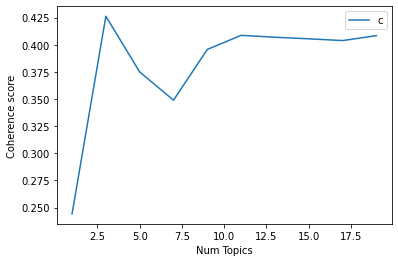

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word_neg, corpus=corpus_neg, texts=data_ready_neg, start=1, limit=20, step=2)
# Show graph
import matplotlib.pyplot as plt
limit=20; start=1; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_neg,
                                           id2word=id2word_neg,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
                                           

pprint(lda_model.print_topics())

[(0,
  '0.077*"available" + 0.073*"product" + 0.053*"checker" + 0.035*"store" + '
  '0.033*"shopping" + 0.027*"shop" + 0.020*"half" + 0.018*"live" + 0.018*"guy" '
  '+ 0.017*"deliver"'),
 (1,
  '0.079*"keep" + 0.074*"address" + 0.043*"load" + 0.026*"tell" + 0.024*"yet" '
  '+ 0.023*"frustrating" + 0.022*"enter" + 0.020*"accept" + 0.020*"email" + '
  '0.018*"disappointing"'),
 (2,
  '0.085*"time" + 0.071*"great" + 0.057*"download" + 0.033*"delivery" + '
  '0.030*"purchase" + 0.025*"waste" + 0.020*"love" + 0.016*"slot" + '
  '0.015*"day" + 0.014*"brand"'),
 (3,
  '0.126*"item" + 0.078*"stock" + 0.030*"product" + 0.026*"order" + '
  '0.026*"service" + 0.024*"always" + 0.021*"store" + 0.019*"extra" + '
  '0.019*"choose" + 0.017*"pay"'),
 (4,
  '0.062*"money" + 0.057*"order" + 0.044*"refund" + 0.042*"still" + '
  '0.041*"amount" + 0.039*"receive" + 0.037*"account" + 0.031*"day" + '
  '0.026*"never" + 0.025*"fix"'),
 (5,
  '0.132*"update" + 0.064*"card" + 0.063*"payment" + 0.029*"stop" + '
 

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as pygen
pyLDAvis.enable_notebook()
vis = pygen.prepare(lda_model, corpus_neg, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.251405  0.085569       1        1  22.960365
9     -0.140449 -0.038341       2        1  14.855132
3     -0.148047 -0.186660       3        1  14.400846
4     -0.178898  0.149925       4        1  10.233257
0      0.012102 -0.290107       5        1   8.342736
1      0.154587  0.058997       6        1   6.547456
2      0.008199  0.169627       7        1   6.362702
8      0.192811 -0.024789       8        1   5.581611
6      0.178567  0.003226       9        1   5.517152
5      0.172534  0.072553      10        1   5.198742, topic_info=        Term         Freq        Total Category  logprob  loglift
111     item  1287.000000  1287.000000  Default  30.0000  30.0000
30      time  1336.000000  1336.000000  Default  29.0000  29.0000
139    stock   803.000000   803.000000  Default  28.0000  28.0000
18     order  2391.000000  2391.000000  Default  27.0000  27.0000
266   update   487.000000   487.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1669    like    22.577788    23.692688  Topic10  -5.0962   2.9086
1749   cause    22.193136    23.306906  Topic10  -5.1133   2.9078
876   detail    56.804247    68.056881  Topic10  -4.1735   2.7760
63      help    50.814445   105.046438  Topic10  -4.2850   2.2305
73     store    32.281247   536.527316  Topic10  -4.7386   0.1461

[445 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
336       1  0.643867        able
336       6  0.355415        able
173       3  0.987957  absolutely
842       6  0.986395      accept
868       7  0.970397      access
...     ...       ...         ...
33        5  0.083679        work
33        8  0.126204        work
33        9  0.348434        work
267      10  0.977443       worth
257       6  0.991168         yet

[492 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 4, 5, 1, 2, 3, 9, 7, 6])

In [ ]:
pyLDAvis.save_html(vis, 'NegativeTopics.html')

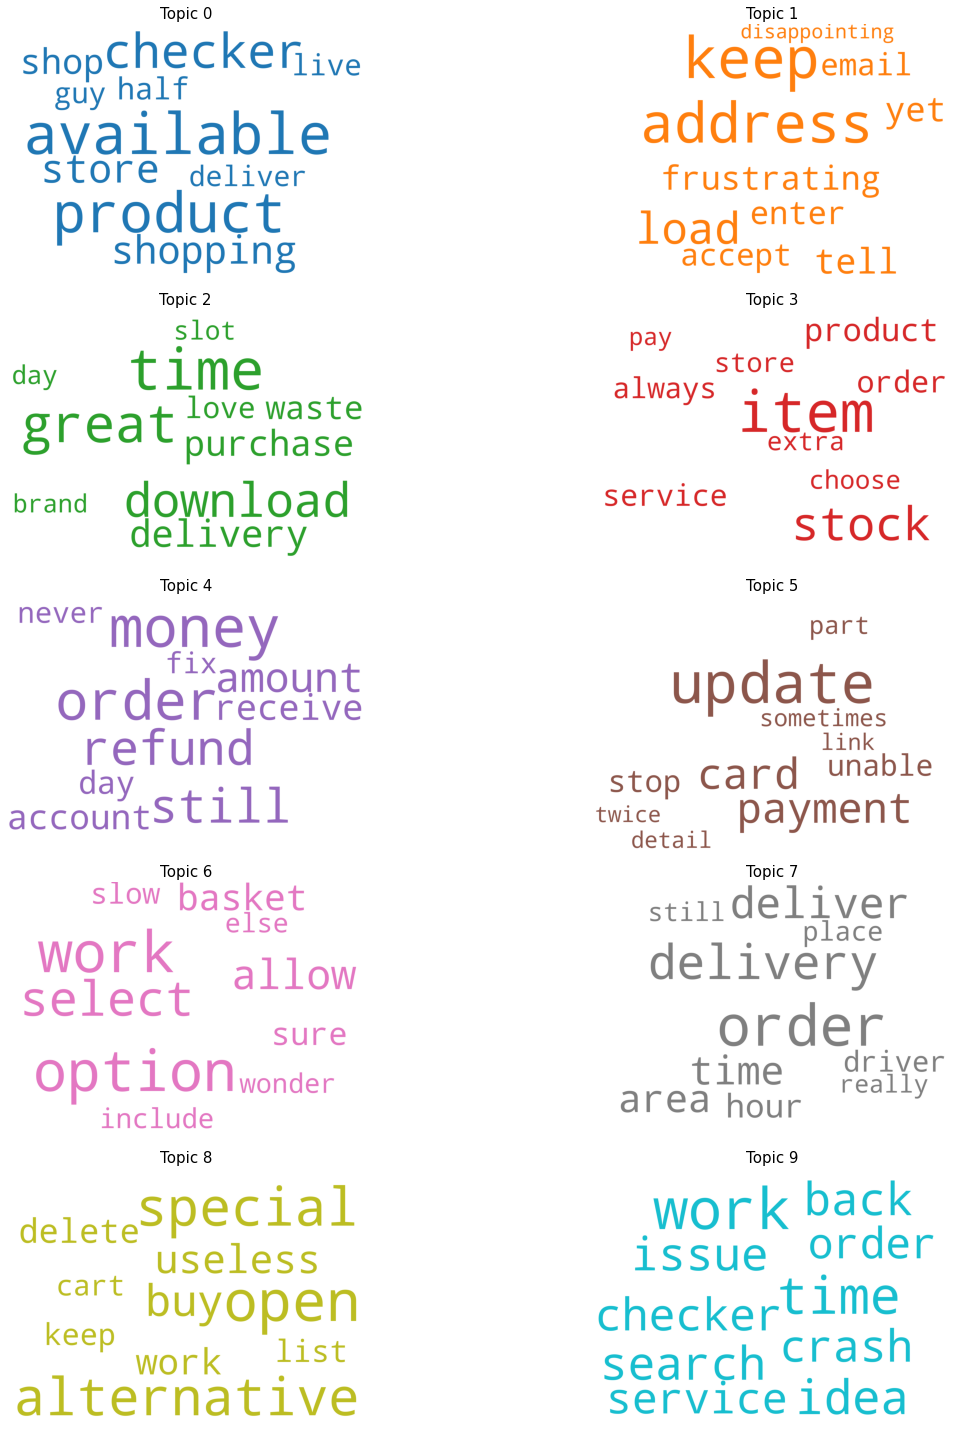

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)



fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=15))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('neg_wordcloud_plot.png', dpi=300)
plt.show()


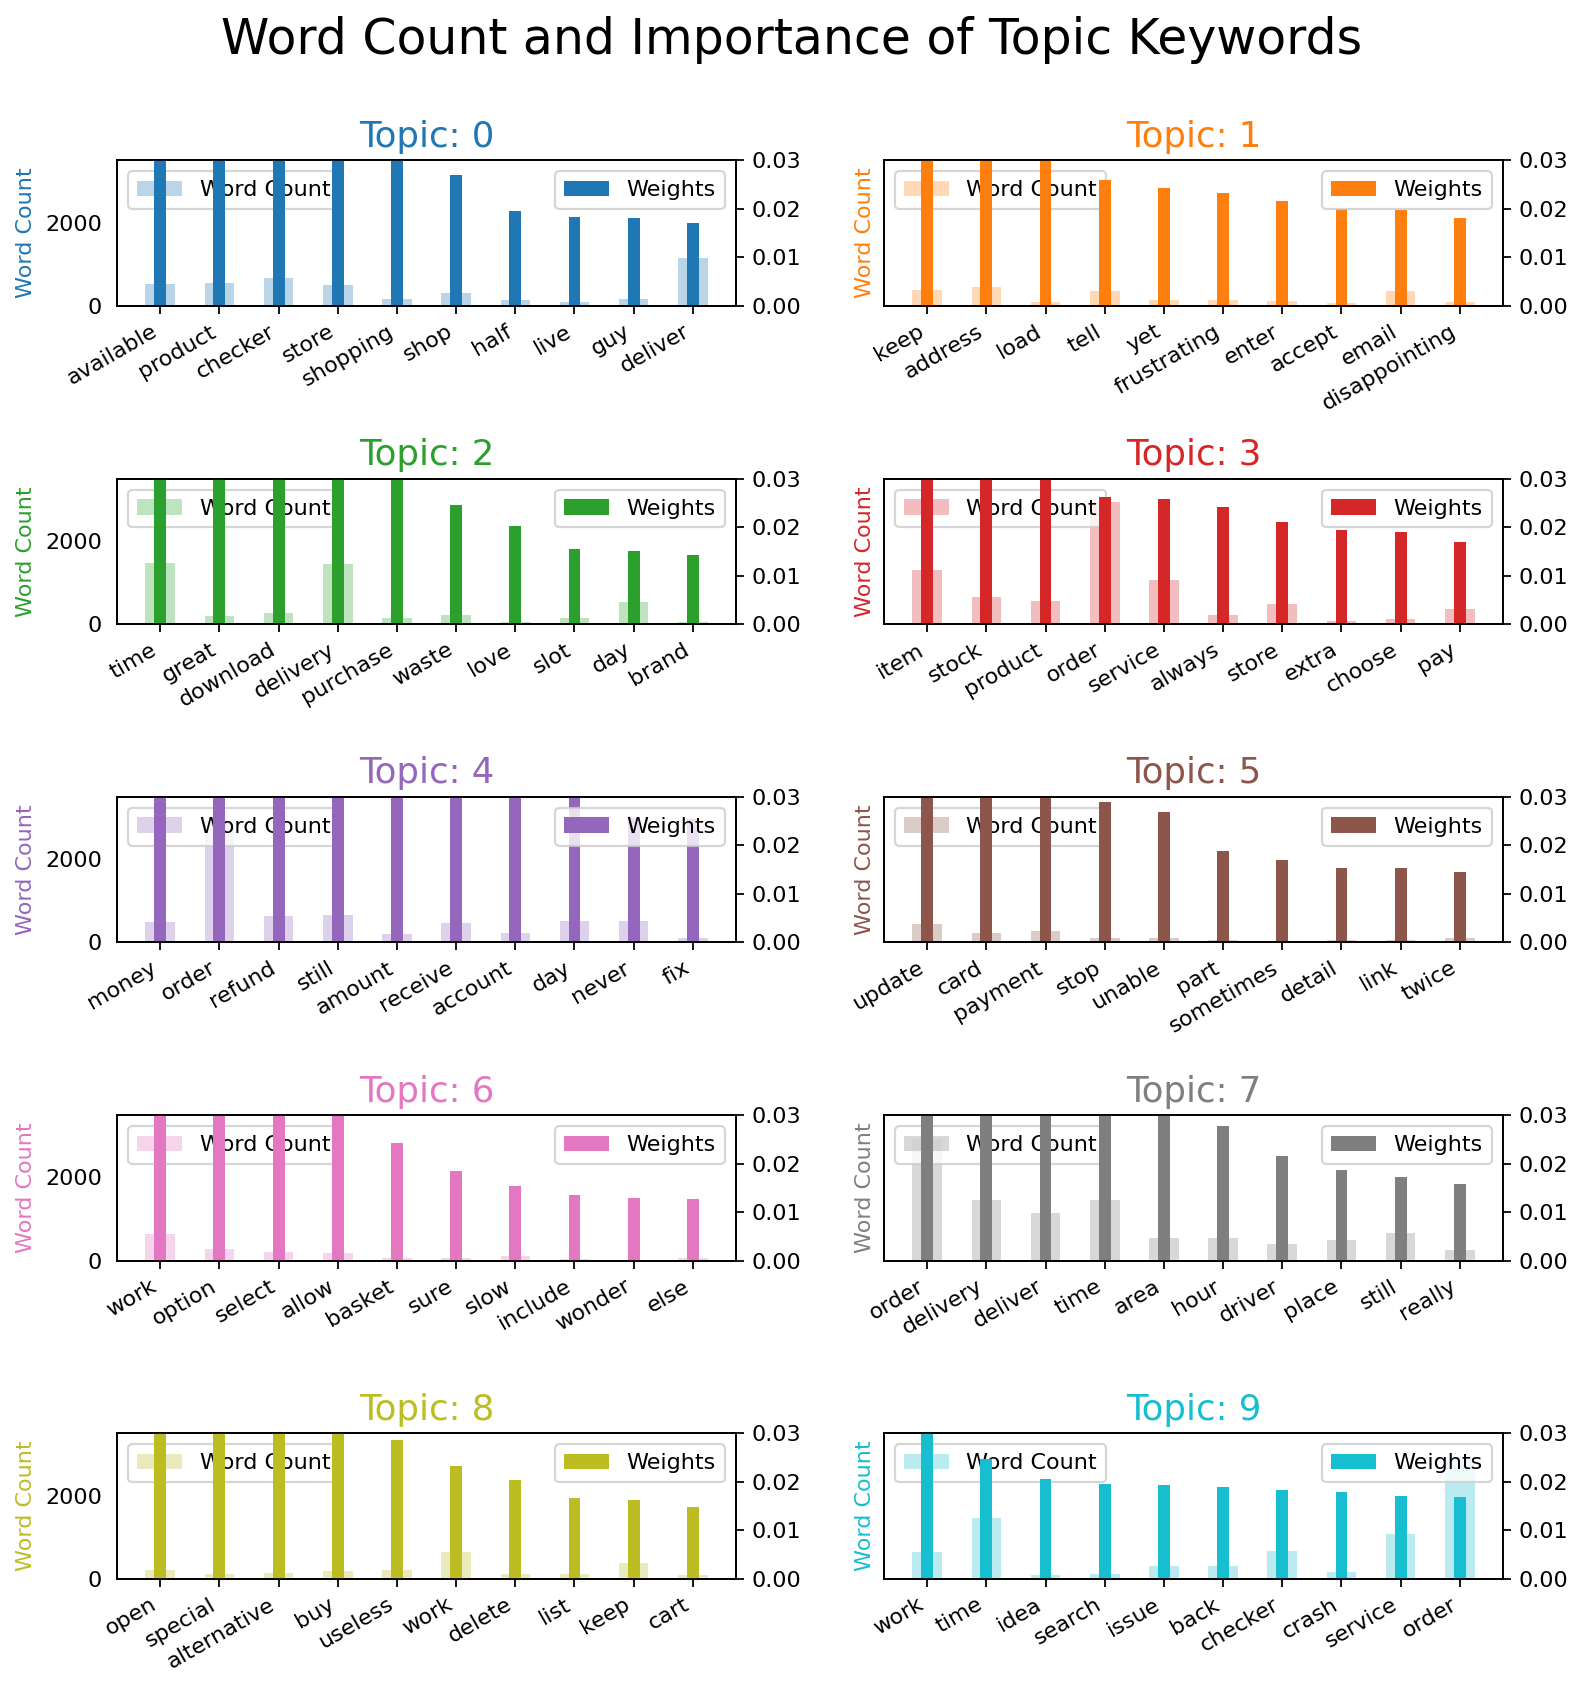

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready_neg for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

**Observations**

Based on the above word frequency plots, wordclouds and pyLDAvis plots, we can deduce that the main problems customers had with the grocery apps are as follows:

- The lack of product availability. It may be that the products shown on the apps are not always available to be ordered which can be frustrating. Although the positive reviews seems to allue to the fact that there is almost always stock available and if not, staff assists you with alternative solutions.
- Customers have trouble loading the app and entering their email addresses/home addresses on the apps for delivery
- They have difficulty with the card payments and updating their card details on the app.
- The apps are slow, especially regarding adding items to the carts.
- When customers cancel orders or request refunds, they do not always get the refunds, and the order comes even though they tried cancelling. They may have issues with bank charges or trouble reversing payments on the apps because of this.
- It appears that when issues are reported, especially pertaining to account problems, card updates and refunding, they are never fixed.
- The apps crash or freeze occasionally.
- Sometimes delivery takes very long in certain areas. This can be due to the location of the area.


#### **1.3.How have the things people like or hate about the grocery delivery apps changed over time.**


##### How things people like changed over time:

In [ ]:
  def format_topics_sentences(ldamodel=None, corpus=corpus_pos, texts=data_):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords_pos = format_topics_sentences(ldamodel=lda_model_pos, corpus=corpus_pos, texts=data_ready_pos)

# Format
df_dominant_topic_Pos = df_topic_sents_keywords_pos.reset_index()
df_dominant_topic_Pos.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_Pos.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.3899,"delivery, friendly, love, minute, driver, opti...","[pleasant, customer, care, experience, day, re..."
1,1,4.0,0.4654,"delivery, friendly, love, minute, driver, opti...","[friendly, delivery, fast, advice, item, avail..."
2,2,6.0,0.4039,"item, order, time, stock, brilliant, product, ...","[test, today, first, happy, suggestion, allow,..."
3,3,6.0,0.2653,"item, order, time, stock, brilliant, product, ...","[really, enjoy, experience, online, shopping, ..."
4,4,7.0,0.3742,"excellent, service, love, great, well, work, a...","[service, fast, accurate, bit, polish, work, w..."
5,5,2.0,0.3071,"impress, delivery, perfect, home, tip, purchas...","[fantastic, placing, order, delivery, receive,..."
6,6,6.0,0.3110,"item, order, time, stock, brilliant, product, ...","[least, week, time, reason, give, fresh, produ..."
7,7,0.0,0.3467,"good, time, order, delivery, service, deliver,...","[delivery, fast, time, time, range, slightly, ..."
8,8,4.0,0.5638,"delivery, friendly, love, minute, driver, opti...","[issue, service, often, product, available, st..."
9,9,4.0,0.4195,"delivery, friendly, love, minute, driver, opti...","[enter, cart, soon, pop, short, cart, easily, ..."


In [ ]:

df_dominant_topic_Pos.to_csv('Positive_reviews.csv')

In [ ]:
dom_pos = pd.read_csv('Positive_reviews.csv')

In [ ]:
dom_pos.tail()

,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
5009,5009,5009,0.0,0.55,"good, time, order, delivery, service, deliver,...",['good']
5010,5010,5010,7.0,0.55,"excellent, service, love, great, well, work, a...",['love']
5011,5011,5011,0.0,0.55,"good, time, order, delivery, service, deliver,...",['good']
5012,5012,5012,7.0,0.55,"excellent, service, love, great, well, work, a...",['love']
5013,5013,5013,0.0,0.55,"good, time, order, delivery, service, deliver,...",['cool']


In [ ]:
df1 = dom_pos
df1.head()

,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,4.0,0.3899,"delivery, friendly, love, minute, driver, opti...","['pleasant', 'customer', 'care', 'experience',..."
1,1,1,4.0,0.4654,"delivery, friendly, love, minute, driver, opti...","['friendly', 'delivery', 'fast', 'advice', 'it..."
2,2,2,6.0,0.4039,"item, order, time, stock, brilliant, product, ...","['test', 'today', 'first', 'happy', 'suggestio..."
3,3,3,6.0,0.2653,"item, order, time, stock, brilliant, product, ...","['really', 'enjoy', 'experience', 'online', 's..."
4,4,4,7.0,0.3742,"excellent, service, love, great, well, work, a...","['service', 'fast', 'accurate', 'bit', 'polish..."


In [ ]:
date = pd.to_datetime(df_pos['Date'])
df1 = dom_pos.join(date)


In [ ]:
df1.head()

,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Date
0,0,0,4.0,0.3899,"delivery, friendly, love, minute, driver, opti...","['pleasant', 'customer', 'care', 'experience',...",NaT
1,1,1,4.0,0.4654,"delivery, friendly, love, minute, driver, opti...","['friendly', 'delivery', 'fast', 'advice', 'it...",NaT
2,2,2,6.0,0.4039,"item, order, time, stock, brilliant, product, ...","['test', 'today', 'first', 'happy', 'suggestio...",NaT
3,3,3,6.0,0.2653,"item, order, time, stock, brilliant, product, ...","['really', 'enjoy', 'experience', 'online', 's...",NaT
4,4,4,7.0,0.3742,"excellent, service, love, great, well, work, a...","['service', 'fast', 'accurate', 'bit', 'polish...",NaT


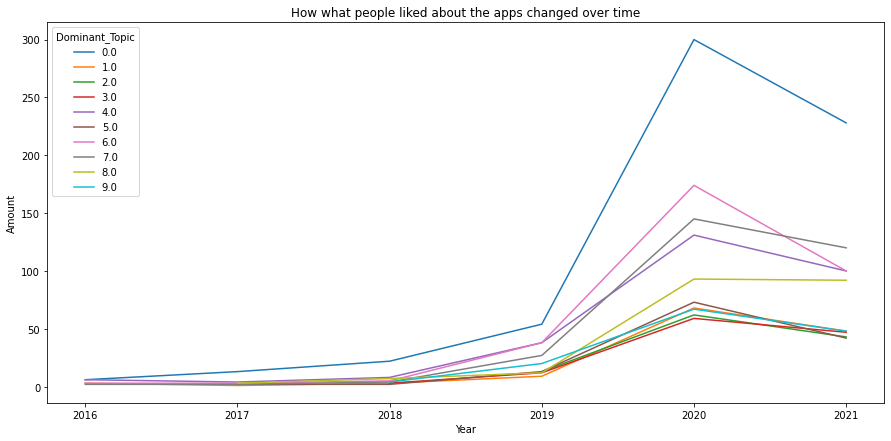

In [ ]:
# plot data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df1.groupby([(df1.Date.dt.year),(df1["Dominant_Topic"])]).size().unstack().plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Amount')
ax.set_title('How what people liked about the apps changed over time');

**Observations**

Based on the above plot, the trend of all aspects liked about the app appear to follow the same pattern. From 2016 to 2018 there were less than 50 positive reviews, perhaps due to how new the app was, with few people using it. It appears that in 2019, more people left positive reviews. This spike in people reviewing the app alludes to the fact that more people use it. It could also refer to the app improving immensely with the updates and possible new features, as one of the topics speak about how great the app features are.However, much more people seemed to be satisfied with the timely delivery and good customer service than anything else. This makes sense as it was during this time that the lockdown was implemented and thus people hardly left hteir homes and neeeded an alternative shopping solution. From 2020, fewer people were leaving positive reviews about the app. Thus, less people were satisfied with the app. However, most people were still happy with delivery time. Fewever people left positive reviews regarding the shopping experience and app features,fast customer service and the convinience of the app

---



##### How things people dislike change over time:

In [ ]:
df_topic_sents_keywords_neg = format_topics_sentences(ldamodel=lda_model, corpus=corpus_neg, texts=data_ready_neg)

# Format
df_dominant_topic_neg = df_topic_sents_keywords_neg.reset_index()
df_dominant_topic_neg.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_neg.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.4622,"work, option, select, allow, basket, sure, slo...","[selection, small, pack, fairly, quickly, deli..."
1,1,7.0,0.3216,"order, delivery, deliver, time, area, hour, dr...","[bad, service, ever, order, grocery, receive, ..."
2,2,7.0,0.5812,"order, delivery, deliver, time, area, hour, dr...","[service, deteriorate, order, incomplete, wron..."
3,3,4.0,0.5144,"money, order, refund, still, amount, receive, ...","[order, input, promo_code, pay, malfunction, l..."
4,4,0.0,0.3475,"available, product, checker, store, shopping, ...","[highly, disappointed, service, always, item, ..."
5,5,9.0,0.5964,"work, time, idea, search, issue, back, checker...","[terrible, experience, forever, back, chat, fe..."
6,6,3.0,0.5426,"item, stock, product, order, service, always, ...","[bad, online, shopping, experience, ever, plac..."
7,7,0.0,0.3084,"available, product, checker, store, shopping, ...","[soon, possible, never, poor, service, deliver..."
8,8,9.0,0.6485,"work, time, idea, search, issue, back, checker...","[first, time, today, last, time, horrible, exp..."
9,9,3.0,0.7388,"item, stock, product, order, service, always, ...","[horrible, experience, packer, pack, powder, i..."


In [ ]:
df2 = df_dominant_topic_neg
df2['Date'] = pd.to_datetime(df_neg['Date'])
df2.head()


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Date
0,0,6.0,0.4622,"work, option, select, allow, basket, sure, slo...","[selection, small, pack, fairly, quickly, deli...",2021-09-12 13:28:00
1,1,7.0,0.3216,"order, delivery, deliver, time, area, hour, dr...","[bad, service, ever, order, grocery, receive, ...",2021-10-18 17:55:00
2,2,7.0,0.5812,"order, delivery, deliver, time, area, hour, dr...","[service, deteriorate, order, incomplete, wron...",2021-10-15 09:49:00
3,3,4.0,0.5144,"money, order, refund, still, amount, receive, ...","[order, input, promo_code, pay, malfunction, l...",2021-10-14 18:56:00
4,4,0.0,0.3475,"available, product, checker, store, shopping, ...","[highly, disappointed, service, always, item, ...",2021-10-11 09:30:00


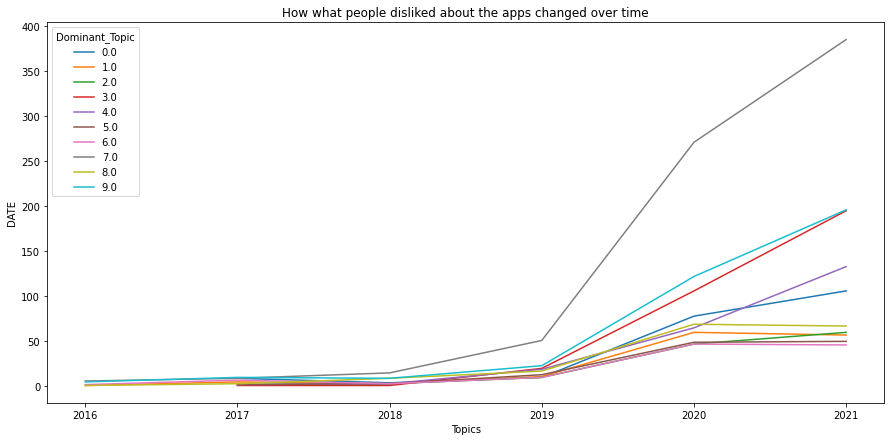

In [ ]:
# plot data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df2.groupby([(df2.Date.dt.year),(df2["Dominant_Topic"])]).size().unstack().plot(ax=ax)
ax.set_xlabel('Topics')
ax.set_ylabel('DATE')
ax.set_title('How what people disliked about the apps changed over time');

**Observations**
- Over the years, people have complained the most about how long it takes for groceries to be delivered in their areas. This problem has increased from 2019 signifcantly. This is possibly due to the influx of people using the app and thus it may be difficul to keep up with deliveries, especially for areas that are quite far from the store. There has never been a decrease in people complaining about this problem, which shows that it is a problem that has not been addressed adequetely.
- 



#### **1.4.Based on the themes generated from your LDA model, compare the different apps and provide a discussion on the identified differences**

In [ ]:
df1['App_id'] = df_pos['appId']
df2['App_id'] = df_neg['appId']

In [ ]:
df1_pos = df_pos.copy()

df1_pos['Dominant_Topic'] = dom_pos['Dominant_Topic']
df1_pos.sample(10)

,appId,Date,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,sortOrder,thumbsUpCount,userImage,userName,Dominant_Topic
9050,za.co.shoprite.sixty60,2021/08/28 18:00,Easy and convenient to shop and always on time...,2021/09/04 14:10,"Hi Janice, thank you so much for your review a...",1.3.31,gp:AOqpTOEPWBKGdYWN9U2y3bxUKP9MGSVpGffQHksgXBr...,4,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Janice Scheepers,NaN
2717,com.bottles,2020/04/22 15:00,Great first experience. App is easy to use and...,NaN,NaN,4.7,gp:AOqpTOEZgeONW7ogKYo4LgsXyZZrgp5iiv9azLd8jx8...,5,newest,2,https://play-lh.googleusercontent.com/a-/AOh14...,Bennie Schonfeldt,1.0
4446,za.co.onecart.onecart,2020/02/23 12:02,I installed the app this morning 23.02.2020 an...,2020/03/05 07:57,"Hello, Thobile. We’re happy that we could make...",v2.10.0.2,gp:AOqpTOEz64OUhKdl1rL92qsEQoyxlVo_R8a3himLJ8w...,5,newest,1,https://play-lh.googleusercontent.com/a-/AOh14...,T N Mkhize,6.0
11089,za.co.shoprite.sixty60,2021/04/06 15:37,Great Service,2021/04/13 12:33,"Hi, thank you so much for your review and 5-st...",1.3.21,gp:AOqpTOEQjoO1ui7gDUHGFViuSttBOAmAUmdOecdCOtm...,5,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Buhle Dlula,NaN
10533,za.co.shoprite.sixty60,2021/03/21 16:52,I relied on this app a lot during quarantine a...,2021/03/22 09:05,"Hi, thank you so much for your review and 5-st...",1.3.21,gp:AOqpTOHb1Q1JdWDB_T3yogPf6howmVoVSUTnPcYLA8f...,5,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Dominique Bartholomew-Buck,NaN
9996,za.co.shoprite.sixty60,2020/12/31 19:05,Great app and great concept. Just love orderin...,2021/01/01 10:00,"Hi Audette, thank you so much for your review ...",1.3.15,gp:AOqpTOGmVf5R8scblsErgLywxuq3-xmi8w6yHicAj_V...,5,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Audette Reddy,NaN
9321,za.co.shoprite.sixty60,2020/09/27 15:11,I love this app. The choices are a bit limited...,2020/09/28 16:30,Hi Janavi. Thank you so much for your positive...,1.3.10,gp:AOqpTOG3hAxs6WBtLPYBQsegahnlcO1Pz-0Uw7N6_Ef...,4,newest,0,https://play-lh.googleusercontent.com/a-/AOh14...,Janavi Da Silva,NaN
9072,za.co.shoprite.sixty60,2021/06/24 09:29,"Thank you for rectifying this, my address show...",2020/10/25 08:17,"Hi, we're sorry to hear this. We are working c...",1.3.26,gp:AOqpTOG0MyWFi7ulEL_--s-EaQgaorlnfdW-FzXT5P8...,4,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,KB G,NaN
2229,com.bottles,2021/07/27 12:21,Everything Is spot on with the app .. you just...,2021/07/28 00:48,It is delightful to hear such positive words a...,5.6,gp:AOqpTOEThx0U9Vlv37MlB7gPe4RCCXhKrSjCX-JPz21...,5,newest,26,https://play-lh.googleusercontent.com/a/AATXAJ...,Yokuphila Mthembu,6.0
4355,za.co.onecart.onecart,2020/07/30 14:01,Good but you should be anle to add to the orde...,NaN,NaN,v2.11.6.0,gp:AOqpTOF3J6N1rUvKr5C-RxrucR5IlgeO9ZGAy-zwrWP...,4,newest,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Linda McWilliams,4.0


<Figure size 1440x1440 with 0 Axes>

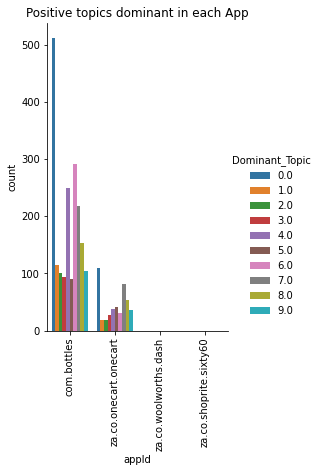

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.catplot(x="appId", hue="Dominant_Topic", aspect=.7,
            kind="count", data=df1_pos)
plt.xticks(rotation=90)
plt.title('Positive topics dominant in each App');

<Figure size 1440x1440 with 0 Axes>

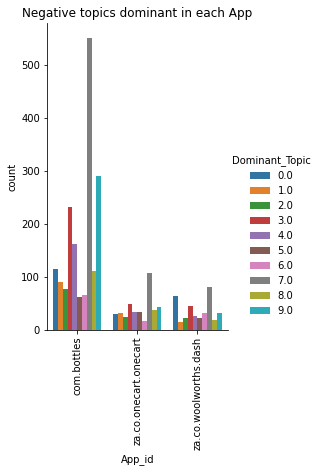

In [ ]:
plt.figure(figsize=(20,20));
sns.catplot(x="App_id", hue="Dominant_Topic", aspect=.7,
            kind="count", data=df2)
plt.xticks(rotation=90)
plt.title('Negative topics dominant in each App');